In [1]:
import pygeostat as gs
import numpy as np
import pandas as pd

In [2]:
#tucs = gs.DataFile('tucs_formation')

In [3]:
#tucs = tucs.data.dropna()

In [4]:
#tucs = tucs[tucs['Formation'] != 6]

In [5]:
#np.unique(tucs['Formation'])

In [6]:
#gs.write_gslib(tucs, 'tucs_cleaned.dat')

In [7]:
tucs = gs.DataFile('tucs_cleaned.dat')

In [8]:
tucs.head()

,X,Y,Z,Formation
0,16277.910156,23019.710938,5765.930176,3.0
1,16277.910156,23019.710938,5740.930176,3.0
2,16277.910156,23019.710938,5715.930176,3.0
3,16277.910156,23019.710938,5690.930176,3.0
4,16277.910156,23019.710938,5665.930176,3.0


In [9]:
tucs.spacing(8)

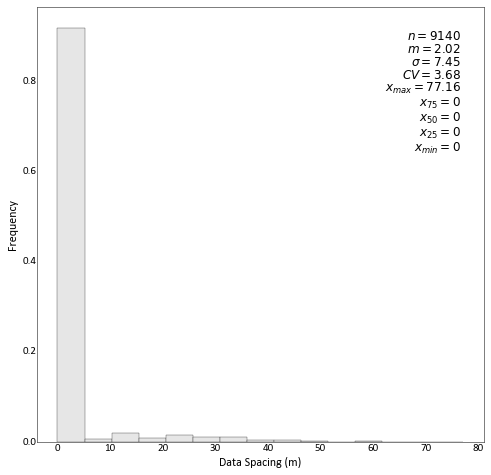

In [10]:
_ = gs.histogram_plot(tucs, var='Data Spacing (m)')

In [11]:
#gs.write_vtk(tucs, 'tucs_points')

In [12]:
nx, ny, nz = 70, 60, 57
xsiz, ysiz, zsiz = 50, 50, 25
xmn, ymn, zmn = 14300, 22500, 4512.5
grid = gs.GridDef([nx, xmn, xsiz, ny, ymn, ysiz, nz, zmn, zsiz])

In [13]:
explicit = gs.DataFile('explicit_model', griddef=grid)

In [14]:
explicit.head()

,Formation
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [15]:
explicit['Formation'] = np.where(explicit['Formation'] == 6, float('nan'), explicit['Formation'])

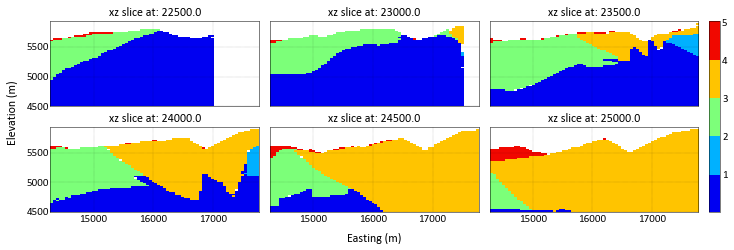

In [16]:
_ = gs.grid_slice_plot(explicit, griddef=grid, cmap='jet', grid=True, orient='xz', output_file='explicit_slicces.png', n_slice=6, figsize=(12,12))

In [17]:
var_calc = gs.Program('varcalc.exe', getpar=True)

D:\Google Drive\Academia\papers\Assessing geological model uncertainty using signed distances and probability fields - REM\tmpx2itben7\varcalc.par has been copied to the clipboard


In [18]:
var_model = gs.Program('varmodel.exe', getpar=True)

D:\Google Drive\Academia\papers\Assessing geological model uncertainty using signed distances and probability fields - REM\tmpfyzqhzl7\varmodel.par has been copied to the clipboard


In [19]:
parstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
tucs_cleaned.dat                 -file with data
1   2   3                         -   columns for X, Y, Z coordinates
1   4   4                         -   number of variables,column numbers (position used for tail,head variables below)
-998.0    1.0e21                  -   trimming limits
2                                 -number of directions
0.0 91 50 0.0 22.5 50 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
50  30.0  15.0                 -        number of lags,lag distance,lag tolerance
0.0 22.5 50 90.0 22.5 50 0.0   -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
50  15.0  7.5                 -        number of lags,lag distance,lag tolerance
{outfl}                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
0                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   10 {cat} {sill}                     -tail variable, head variable, variogram type (and cutoff/category), sill
"""

cat = 1

prop = np.sum(tucs['Formation']==cat)/len(tucs['Formation'])
var = prop - prop ** 2
parstr_e = parstr.format(
outfl='exp_var_{}.out'.format(cat),
cat=cat,
sill=var,
)

var_calc.run(parstr=parstr_e, liveoutput=True, parfile='varcalc_cat_{}.par'.format(cat))

Calling:  ['varcalc.exe', 'varcalc_cat_1.par']

varcalc version:  1.400

  data file: tucs_cleaned.dat
  x,y,z columns:            1           2           3
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            2
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   91.0000000000000     
   50.0000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   50.0000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          50   30.0000000000000     
   15.0000000000000     
 azm,azmtol,bandhorz  0.000000000000000E+000   22.5000000000000     
   50.0000000000000     
 dip,diptol,bandvert   90.0000000000000        22.5000000000000     
   50.0000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          50   15.0000000000000     
   7.50000000000000     
  output file: exp_var_1.out
  legacy output?    

In [20]:
parstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{model_points}                 -file for modeled variogram points output
2                            -number of directions to model points along
  0.0   0.0  1000   2      -  azm, dip, npoints, point separation
  0.0   90.0  1000   2      -  azm, dip, npoints, point separation
1    0:0.1                   -nst, nugget effect
1    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
{sill}                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{exp}                  -    experimental output file 1
0   1   4                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     1.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
1      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{var_model}              -  file to save fit variogram model
"""

cat = 1    
parstr_e = parstr.format(
exp='exp_var_{}.out'.format(cat),
model_points='model_pts_var_{}.out'.format(cat),
var_model='model_var_{}.out'.format(cat),
sill=var,
)

var_model.run(parstr=parstr_e, liveoutput=True, parfile='varmodel_cat_{}.par'.format(cat))

Calling:  ['varmodel.exe', 'varmodel_cat_1.par']

varmodel version: 1.1.1

  output points file: model_pts_var_1.out
  number of directions to model points along:            2
  azm, dip, npoints, pointsep:   0.000000000000000E+000  0.000000000000000E+000
        1000   2.00000000000000     
  azm, dip, npoints, pointsep:   0.000000000000000E+000   90.0000000000000     
        1000   2.00000000000000     
  nst =           1
 c0 constrained to  0.000000000000000E+000  0.100000000000000     
  fit model?            1      100000
  number of variogram files:            1
  variogram file: exp_var_1.out
  using all experimental variograms in this file
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            0   1.00000000000000     
  fixhminhmax,hminhmax:            1   1.00000000000000     
  variogram model output file: model_var_1.out
 Reading experimental variograms for variogram fitting
  Fitting variograms
 Starting objective va

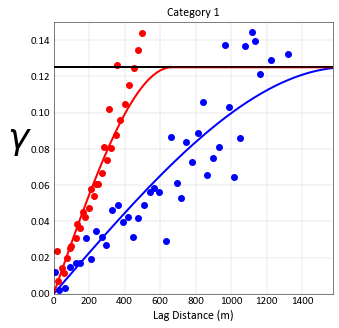

In [21]:
cat = 1
varfl = gs.DataFile('exp_var_{}.out'.format(cat))
modelfl=gs.DataFile('model_pts_var_{}.out'.format(cat))
_ = gs.variogram_plot(varfl, index=1, grid=True, ms=7, figsize=(5,5), color='blue', title="Category {}".format(cat), sill=var, ylim=[0,var+0.2*var])
gs.variogram_plot(modelfl, index=1, experimental=False, ax= _, lw=2, color='blue', sill=var, ylim=[0,var+0.2*var])
gs.variogram_plot(varfl, index=2, ax= _, grid=True, ms=7, color='red', sill=var, ylim=[0,var+0.2*var])
gs.variogram_plot(modelfl, index=2, experimental=False, ax= _, output_file='cat_var_{}.png'.format(cat), lw=2, color='red', label="vertical", sill=var, ylim=[0,var+0.2*var])

In [22]:
parstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
tucs_cleaned.dat                 -file with data
1   2   3                         -   columns for X, Y, Z coordinates
1   4   4                         -   number of variables,column numbers (position used for tail,head variables below)
-998.0    1.0e21                  -   trimming limits
1                                 -number of directions
90.0 91 1000 0.0 91 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
50  15  7.5                 -        number of lags,lag distance,lag tolerance
{outfl}                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
0                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   10 {cat} {sill}                     -tail variable, head variable, variogram type (and cutoff/category), sill
"""

cat = 2

prop = np.sum(tucs['Formation']==cat)/len(tucs['Formation'])
var = prop - prop ** 2
parstr_e = parstr.format(
outfl='exp_var_{}.out'.format(cat),
cat=cat,
sill=var,
)

var_calc.run(parstr=parstr_e, liveoutput=True, parfile='varcalc_cat_{}.par'.format(cat))

Calling:  ['varcalc.exe', 'varcalc_cat_2.par']

varcalc version:  1.400

  data file: tucs_cleaned.dat
  x,y,z columns:            1           2           3
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            1
  direction parameters:
 azm,azmtol,bandhorz   90.0000000000000        91.0000000000000     
   1000.00000000000     
 dip,diptol,bandvert  0.000000000000000E+000   91.0000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          50   15.0000000000000     
   7.50000000000000     
  output file: exp_var_2.out
  legacy output?            0
  run checks?            1
  attempt to standardize sills?            0
  number of variogram types:            1
 Variogram tail,head,type           1           1          10
  cutoff/category   2.00000000000000     
 Reading data file
 Setting up final parameters for variogram calculation

In [23]:
parstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{model_points}                 -file for modeled variogram points output
1                            -number of directions to model points along
  0.0   0.0  1000   2      -  azm, dip, npoints, point separation
1    0:0.1                   -nst, nugget effect
1    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        250     250     250    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
{sill}                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{exp}                  -    experimental output file 1
0   1   4                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
1     1.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
1      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{var_model}              -  file to save fit variogram model
"""

cat = 2    
parstr_e = parstr.format(
exp='exp_var_{}.out'.format(cat),
model_points='model_pts_var_{}.out'.format(cat),
var_model='model_var_{}.out'.format(cat),
sill=0.003,
)

var_model.run(parstr=parstr_e, liveoutput=True, parfile='varmodel_cat_{}.par'.format(cat))

Calling:  ['varmodel.exe', 'varmodel_cat_2.par']

varmodel version: 1.1.1

  output points file: model_pts_var_2.out
  number of directions to model points along:            1
  azm, dip, npoints, pointsep:   0.000000000000000E+000  0.000000000000000E+000
        1000   2.00000000000000     
  nst =           1
 c0 constrained to  0.000000000000000E+000  0.100000000000000     
  fit model?            1      100000
  number of variogram files:            1
  variogram file: exp_var_2.out
  using all experimental variograms in this file
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            1   1.00000000000000     
  fixhminhmax,hminhmax:            1   1.00000000000000     
  variogram model output file: model_var_2.out
 Reading experimental variograms for variogram fitting
  Fitting variograms
   Are your constraints consistent and possible?
 Starting objective value =   2.915931591905168E-007
 Final objective value =   2.91593159

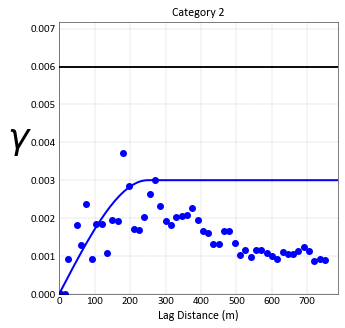

In [24]:
cat = 2
varfl = gs.DataFile('exp_var_{}.out'.format(cat))
modelfl=gs.DataFile('model_pts_var_{}.out'.format(cat))
_ = gs.variogram_plot(varfl, index=1, grid=True, ms=7, figsize=(5,5), color='blue', title="Category {}".format(cat), sill=var, ylim=[0,var+0.2*var])
gs.variogram_plot(modelfl, index=1, experimental=False, ax= _, lw=2, color='blue', output_file='var_{}.png'.format(cat), sill=var, ylim=[0,var+0.2*var])
#gs.variogram_plot(varfl, index=2, ax= _, grid=True, ms=7, color='red', sill=var, ylim=[0,var+0.2*var])
#gs.variogram_plot(modelfl, index=2, experimental=False, ax= _, output_file='cat_var_{}.png'.format(cat), lw=2, color='red', label="vertical", sill=var, ylim=[0,var+0.2*var])

In [25]:
parstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
tucs_cleaned.dat                 -file with data
1   2   3                         -   columns for X, Y, Z coordinates
1   4   4                         -   number of variables,column numbers (position used for tail,head variables below)
-998.0    1.0e21                  -   trimming limits
1                                 -number of directions
0.0 91 1000 0.0 91 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
50  30.0  15.0                 -        number of lags,lag distance,lag tolerance
{outfl}                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
0                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   10 {cat} {sill}                     -tail variable, head variable, variogram type (and cutoff/category), sill
"""

cat = 3

prop = np.sum(tucs['Formation']==cat)/len(tucs['Formation'])
var = prop - prop ** 2
parstr_e = parstr.format(
outfl='exp_var_{}.out'.format(cat),
cat=cat,
sill=var,
)

var_calc.run(parstr=parstr_e, liveoutput=True, parfile='varcalc_cat_{}.par'.format(cat))

Calling:  ['varcalc.exe', 'varcalc_cat_3.par']

varcalc version:  1.400

  data file: tucs_cleaned.dat
  x,y,z columns:            1           2           3
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            1
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   91.0000000000000     
   1000.00000000000     
 dip,diptol,bandvert  0.000000000000000E+000   91.0000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          50   30.0000000000000     
   15.0000000000000     
  output file: exp_var_3.out
  legacy output?            0
  run checks?            1
  attempt to standardize sills?            0
  number of variogram types:            1
 Variogram tail,head,type           1           1          10
  cutoff/category   3.00000000000000     
 Reading data file
 Setting up final parameters for variogram calculation

In [26]:
parstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{model_points}                 -file for modeled variogram points output
1                            -number of directions to model points along
  0.0   0.0  1000   2      -  azm, dip, npoints, point separation
1    0:0.1                   -nst, nugget effect
1    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
{sill}                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{exp}                  -    experimental output file 1
0   1   4                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
1     1.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
1      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{var_model}              -  file to save fit variogram model
"""

cat = 3    
parstr_e = parstr.format(
exp='exp_var_{}.out'.format(cat),
model_points='model_pts_var_{}.out'.format(cat),
var_model='model_var_{}.out'.format(cat),
sill=var,
)

var_model.run(parstr=parstr_e, liveoutput=True, parfile='varmodel_cat_{}.par'.format(cat))

Calling:  ['varmodel.exe', 'varmodel_cat_3.par']

varmodel version: 1.1.1

  output points file: model_pts_var_3.out
  number of directions to model points along:            1
  azm, dip, npoints, pointsep:   0.000000000000000E+000  0.000000000000000E+000
        1000   2.00000000000000     
  nst =           1
 c0 constrained to  0.000000000000000E+000  0.100000000000000     
  fit model?            1      100000
  number of variogram files:            1
  variogram file: exp_var_3.out
  using all experimental variograms in this file
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            1   1.00000000000000     
  fixhminhmax,hminhmax:            1   1.00000000000000     
  variogram model output file: model_var_3.out
 Reading experimental variograms for variogram fitting
  Fitting variograms
 Starting objective value =   1.261211172725723E-005
 Final objective value =   7.858858833513614E-007
  Modeling points

varmodel complete

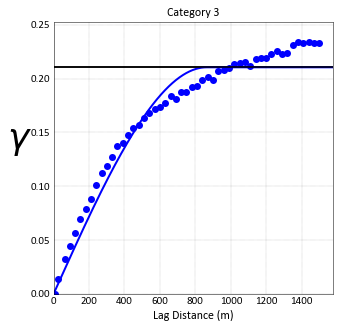

In [27]:
cat = 3
varfl = gs.DataFile('exp_var_{}.out'.format(cat))
modelfl=gs.DataFile('model_pts_var_{}.out'.format(cat))
_ = gs.variogram_plot(varfl, index=1, grid=True, ms=7, figsize=(5,5), color='blue', title="Category {}".format(cat), sill=var, ylim=[0,var+0.2*var])
gs.variogram_plot(modelfl, index=1, experimental=False, ax= _, lw=2, color='blue', output_file='var_{}.png'.format(cat), sill=var, ylim=[0,var+0.2*var])
#gs.variogram_plot(varfl, index=2, ax= _, grid=True, ms=7, color='red', sill=var, ylim=[0,var+0.2*var])
#gs.variogram_plot(modelfl, index=2, experimental=False, ax= _, output_file='cat_var_{}.png'.format(cat), lw=2, color='red', label="vertical", sill=var, ylim=[0,var+0.2*var])

In [28]:
parstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
tucs_cleaned.dat                 -file with data
1   2   3                         -   columns for X, Y, Z coordinates
1   4   4                         -   number of variables,column numbers (position used for tail,head variables below)
-998.0    1.0e21                  -   trimming limits
1                                 -number of directions
0.0 91 1000 0.0 91 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
50  30.0  15.0                 -        number of lags,lag distance,lag tolerance
{outfl}                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
0                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   10 {cat} {sill}                     -tail variable, head variable, variogram type (and cutoff/category), sill
"""

cat = 4

prop = np.sum(tucs['Formation']==cat)/len(tucs['Formation'])
var = prop - prop ** 2
parstr_e = parstr.format(
outfl='exp_var_{}.out'.format(cat),
cat=cat,
sill=var,
)

var_calc.run(parstr=parstr_e, liveoutput=True, parfile='varcalc_cat_{}.par'.format(cat))

Calling:  ['varcalc.exe', 'varcalc_cat_4.par']

varcalc version:  1.400

  data file: tucs_cleaned.dat
  x,y,z columns:            1           2           3
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            1
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   91.0000000000000     
   1000.00000000000     
 dip,diptol,bandvert  0.000000000000000E+000   91.0000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          50   30.0000000000000     
   15.0000000000000     
  output file: exp_var_4.out
  legacy output?            0
  run checks?            1
  attempt to standardize sills?            0
  number of variogram types:            1
 Variogram tail,head,type           1           1          10
  cutoff/category   4.00000000000000     
 Reading data file
 Setting up final parameters for variogram calculation

In [29]:
parstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{model_points}                 -file for modeled variogram points output
1                            -number of directions to model points along
  0.0   0.0  1000   2      -  azm, dip, npoints, point separation
1    0:0.1                   -nst, nugget effect
1    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
{sill}                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{exp}                  -    experimental output file 1
0   1   4                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
1     1.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
1      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{var_model}              -  file to save fit variogram model
"""

cat = 4    
parstr_e = parstr.format(
exp='exp_var_{}.out'.format(cat),
model_points='model_pts_var_{}.out'.format(cat),
var_model='model_var_{}.out'.format(cat),
sill=var,
)

var_model.run(parstr=parstr_e, liveoutput=True, parfile='varmodel_cat_{}.par'.format(cat))

Calling:  ['varmodel.exe', 'varmodel_cat_4.par']

varmodel version: 1.1.1

  output points file: model_pts_var_4.out
  number of directions to model points along:            1
  azm, dip, npoints, pointsep:   0.000000000000000E+000  0.000000000000000E+000
        1000   2.00000000000000     
  nst =           1
 c0 constrained to  0.000000000000000E+000  0.100000000000000     
  fit model?            1      100000
  number of variogram files:            1
  variogram file: exp_var_4.out
  using all experimental variograms in this file
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            1   1.00000000000000     
  fixhminhmax,hminhmax:            1   1.00000000000000     
  variogram model output file: model_var_4.out
 Reading experimental variograms for variogram fitting
  Fitting variograms
 Starting objective value =   8.894088289506512E-006
 Final objective value =   1.556671849360172E-006
  Modeling points

varmodel complete

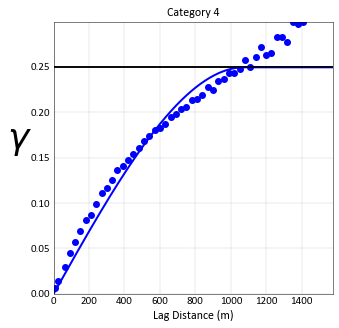

In [30]:
cat = 4
varfl = gs.DataFile('exp_var_{}.out'.format(cat))
modelfl=gs.DataFile('model_pts_var_{}.out'.format(cat))
_ = gs.variogram_plot(varfl, index=1, grid=True, ms=7, figsize=(5,5), color='blue', title="Category {}".format(cat), sill=var, ylim=[0,var+0.2*var])
gs.variogram_plot(modelfl, index=1, experimental=False, ax= _, lw=2, color='blue', output_file='var_{}.png'.format(cat), sill=var, ylim=[0,var+0.2*var])
#gs.variogram_plot(varfl, index=2, ax= _, grid=True, ms=7, color='red', sill=var, ylim=[0,var+0.2*var])
#gs.variogram_plot(modelfl, index=2, experimental=False, ax= _, output_file='cat_var_{}.png'.format(cat), lw=2, color='red', label="vertical", sill=var, ylim=[0,var+0.2*var])

In [31]:
parstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
tucs_cleaned.dat                 -file with data
1   2   3                         -   columns for X, Y, Z coordinates
1   4   4                         -   number of variables,column numbers (position used for tail,head variables below)
-998.0    1.0e21                  -   trimming limits
1                                 -number of directions
0 91 1000 0.0 91 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
50  30.0  15.0                 -        number of lags,lag distance,lag tolerance
{outfl}                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
0                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   10 {cat} {sill}                     -tail variable, head variable, variogram type (and cutoff/category), sill
"""

cat = 5

prop = np.sum(tucs['Formation']==cat)/len(tucs['Formation'])
var = prop - prop ** 2
parstr_e = parstr.format(
outfl='exp_var_{}.out'.format(cat),
cat=cat,
sill=var,
)

var_calc.run(parstr=parstr_e, liveoutput=True, parfile='varcalc_cat_{}.par'.format(cat))

Calling:  ['varcalc.exe', 'varcalc_cat_5.par']

varcalc version:  1.400

  data file: tucs_cleaned.dat
  x,y,z columns:            1           2           3
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            1
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   91.0000000000000     
   1000.00000000000     
 dip,diptol,bandvert  0.000000000000000E+000   91.0000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          50   30.0000000000000     
   15.0000000000000     
  output file: exp_var_5.out
  legacy output?            0
  run checks?            1
  attempt to standardize sills?            0
  number of variogram types:            1
 Variogram tail,head,type           1           1          10
  cutoff/category   5.00000000000000     
 Reading data file
 Setting up final parameters for variogram calculation

In [32]:
parstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{model_points}                 -file for modeled variogram points output
1                            -number of directions to model points along
  0.0   0.0  1000   2      -  azm, dip, npoints, point separation
2    0:0.1                   -nst, nugget effect
1    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
{sill}                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{exp}                  -    experimental output file 1
0   1   4                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
1     1.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
1      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{var_model}              -  file to save fit variogram model
"""

cat = 5    
parstr_e = parstr.format(
exp='exp_var_{}.out'.format(cat),
model_points='model_pts_var_{}.out'.format(cat),
var_model='model_var_{}.out'.format(cat),
sill=var,
)

var_model.run(parstr=parstr_e, liveoutput=True, parfile='varmodel_cat_{}.par'.format(cat))

Calling:  ['varmodel.exe', 'varmodel_cat_5.par']

varmodel version: 1.1.1

  output points file: model_pts_var_5.out
  number of directions to model points along:            1
  azm, dip, npoints, pointsep:   0.000000000000000E+000  0.000000000000000E+000
        1000   2.00000000000000     
  nst =           2
 c0 constrained to  0.000000000000000E+000  0.100000000000000     
  fit model?            1      100000
  number of variogram files:            1
  variogram file: exp_var_5.out
  using all experimental variograms in this file
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            1   1.00000000000000     
  fixhminhmax,hminhmax:            1   1.00000000000000     
  variogram model output file: model_var_5.out
 Reading experimental variograms for variogram fitting
  Fitting variograms
   Are your constraints consistent and possible?
 Starting objective value =   5.977325663932218E-008
 Final objective value =   6.97869026

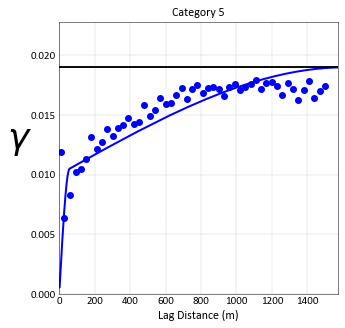

In [33]:
cat = 5
varfl = gs.DataFile('exp_var_{}.out'.format(cat))
modelfl=gs.DataFile('model_pts_var_{}.out'.format(cat))
_ = gs.variogram_plot(varfl, index=1, grid=True, ms=7, figsize=(5,5), color='blue', title="Category {}".format(cat), sill=var, ylim=[0,var+0.2*var])
gs.variogram_plot(modelfl, index=1, experimental=False, ax= _, lw=2, color='blue', output_file='var_{}.png'.format(cat), sill=var, ylim=[0,var+0.2*var])
#gs.variogram_plot(varfl, index=2, ax= _, grid=True, ms=7, color='red', sill=var, ylim=[0,var+0.2*var])
#gs.variogram_plot(modelfl, index=2, experimental=False, ax= _, output_file='cat_var_{}.png'.format(cat), lw=2, color='red', label="vertical", sill=var, ylim=[0,var+0.2*var])

In [34]:
sisim = gs.Program('sisim.exe', getpar=True)

D:\Google Drive\Academia\papers\Assessing geological model uncertainty using signed distances and probability fields - REM\tmpmv053u9w\sisim.par has been copied to the clipboard


In [35]:
parstr = """                  Parameters for SISIM
                  ********************

START OF PARAMETERS:
0                             -1=continuous(cdf), 0=categorical(pdf)
5                             -number thresholds/categories
1   2   3   4   5  -   thresholds / categories
0.14649890590809628  0.006017505470459519  0.3010940919037199  0.5270240700218818  0.01936542669584245  -   global cdf / pdf
tucs_cleaned.dat           -file with data
1   2   3   4                 -   columns for X,Y,Z, and variable
direct.ik                     -file with soft indicator input
1   2   0   3 4 5 6 7         -   columns for X,Y,Z, and indicators
0                             -   Markov-Bayes simulation (0=no,1=yes)
0.61  0.54  0.56  0.53  0.29  -      calibration B(z) values
-1.0e21    1.0e21             -trimming limits
0.0   30.0                    -minimum and maximum data value
1      0.0                    -   lower tail option and parameter
1      1.0                    -   middle     option and parameter
1     30.0                    -   upper tail option and parameter
cluster.dat                   -   file with tabulated values
3   0                         -      columns for variable, weight
0                             -debugging level: 0,1,2,3
sisim.dbg                     -file for debugging output
sisim.out                     -file for simulation output
10                             -number of realizations
{grid}
69069                         -random number seed
12                            -maximum original data  for each kriging
12                            -maximum previous nodes for each kriging
1                             -maximum soft indicator nodes for kriging
1                             -assign data to nodes? (0=no,1=yes)
0     3                       -multiple grid search? (0=no,1=yes),num
0                             -maximum per octant    (0=not used)
1500  1500  1500              -maximum search radii
 0.0   0.0   0.0              -angles for search ellipsoid
70    60    57                -size of covariance lookup table
0    2.5                      -0=full IK, 1=median approx. (cutoff)
0                             -0=SK, 1=OK
  2       0.00000    -nst, nugget effect
  1       0.03300       0.00000       0.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
          1.00000        750.06000        750.06000    -a_hmax, a_hmin, a_vert (ranges)
  1       0.96700       0.00000       0.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
       1708.85000       1500.11000       1500.11000    -a_hmax, a_hmin, a_vert (ranges)
  
  2       0.00000    -nst, nugget effect
  1       0.24200       0.00000       0.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
         17.52000        750.06000        750.06000    -a_hmax, a_hmin, a_vert (ranges)
  1       0.75800       0.00000       0.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
 6631384422.01000       1592.48000       1500.11000    -a_hmax, a_hmin, a_vert (ranges)

  2       0.00000    -nst, nugget effect
  1       0.36400       0.00000       0.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        420.00000        750.06000        750.06000    -a_hmax, a_hmin, a_vert (ranges)
  1       0.63600       0.00000       0.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
       1124.04000       1500.11000       1500.11000    -a_hmax, a_hmin, a_vert (ranges)

  2       0.00000    -nst, nugget effect
  1       0.18100       0.00000       0.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        327.65000        750.06000        750.06000    -a_hmax, a_hmin, a_vert (ranges)
  1       0.81900       0.00000       0.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
       1220.16000       1500.11000       1500.11000    -a_hmax, a_hmin, a_vert (ranges)

  2       0.00000    -nst, nugget effect
  1       0.60400       0.00000       0.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        116.67000        750.06000        750.06000    -a_hmax, a_hmin, a_vert (ranges)
  1       0.39600       0.00000       0.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
       1572.09000       1500.11000       1500.11000    -a_hmax, a_hmin, a_vert (ranges)
"""

parstr_e = parstr.format(
grid=grid
)

sisim.run(parstr=parstr_e, liveoutput=True, parfile='sisimpar.par')

Calling:  ['sisim.exe', 'sisimpar.par']

 SISIM Version: 3.000

  variable type (1=continuous, 0=categorical)=            0
  number of thresholds / categories =            5
  thresholds / categories =    1.000000       2.000000       3.000000    
   4.000000       5.000000    
  global cdf / pdf        =   0.1464989      6.0175057E-03  0.3010941    
  0.5270241      1.9365426E-02
  data file = tucs_cleaned.dat                        
  input columns =            1           2           3           4
  soft data file = direct.ik                               
  trimming limits       -1.0000000E+21  1.0000000E+21
  data limits (tails)    0.0000000E+00   30.00000    
  lower tail =            1  0.0000000E+00
  middle =            1   1.000000    
  upper tail =            1   30.00000    
  file for tab. quant. cluster.dat                             
  columns for vr wt =            3           0
  debugging level =            0
  debugging file = sisim.dbg                            

   currently on node     10000
   currently on node     20000
   currently on node     30000
   currently on node     40000
   currently on node     50000
   currently on node     60000
   currently on node     70000
   currently on node     80000
   currently on node     90000
   currently on node    100000
   currently on node    110000
   currently on node    120000
   currently on node    130000
   currently on node    140000
   currently on node    150000
   currently on node    160000
   currently on node    170000
   currently on node    180000
   currently on node    190000
   currently on node    200000
   currently on node    210000
   currently on node    220000
   currently on node    230000

 Finished simulation  5
     threshold   1 input cdf = 0.1465 realization cdf = 0.2319
     threshold   2 input cdf = 0.0060 realization cdf = 0.0128
     threshold   3 input cdf = 0.3011 realization cdf = 0.2648
     threshold   4 input cdf = 0.5270 realization cdf = 0.4422
     thres

   currently on node    170000
   currently on node    180000
   currently on node    190000
   currently on node    200000
   currently on node    210000
   currently on node    220000
   currently on node    230000

 Finished simulation 10
     threshold   1 input cdf = 0.1465 realization cdf = 0.2467
     threshold   2 input cdf = 0.0060 realization cdf = 0.0165
     threshold   3 input cdf = 0.3011 realization cdf = 0.2590
     threshold   4 input cdf = 0.5270 realization cdf = 0.4325
     threshold   5 input cdf = 0.0194 realization cdf = 0.0452

 Summary of order relations: 
     threshold 1 number = 230456 average =   0.0052 maximum =   0.8570
     threshold 2 number = 230454 average =   0.0008 maximum =   0.4225
     threshold 3 number = 230456 average =   0.0063 maximum =   0.4057
     threshold 4 number = 230456 average =   0.0072 maximum =   0.4652
     threshold 5 number = 230456 average =   0.0016 maximum =   0.3799

 total of          96.263824% with average of   0.0042



In [36]:
sisim = gs.DataFile('sisim.out')

In [37]:
nreals=10
sisim_vals = np.reshape(sisim.data.values, (grid.count(), nreals), order='F')
sisim_pd = pd.DataFrame(columns=['real {}'.format(c) for c in range(nreals)], data=sisim_vals)

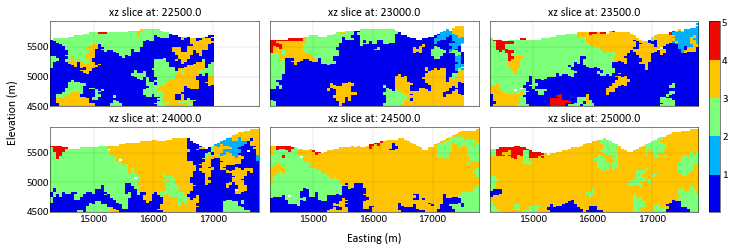

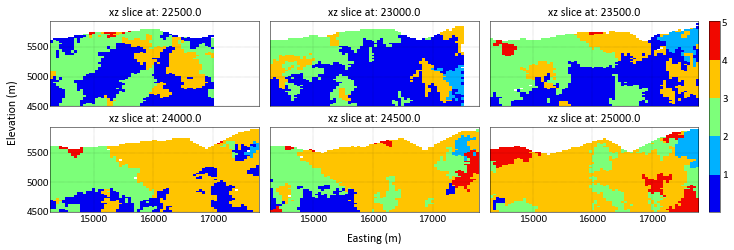

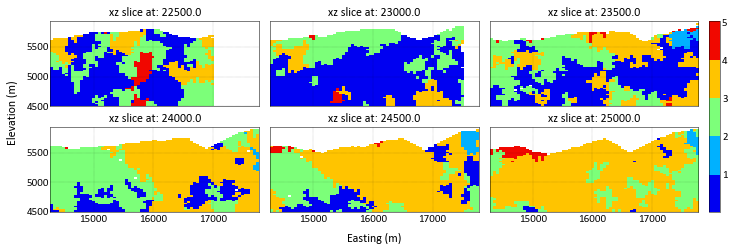

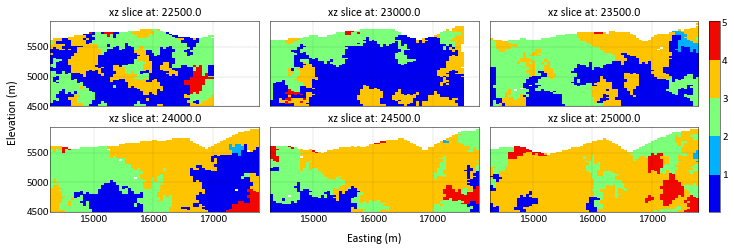

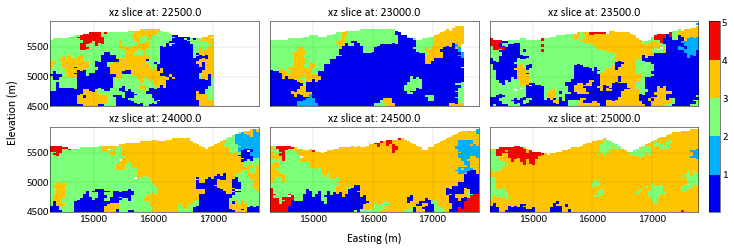

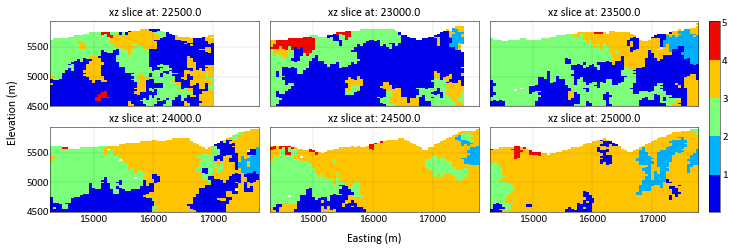

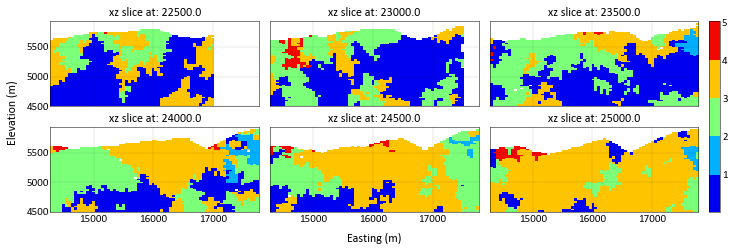

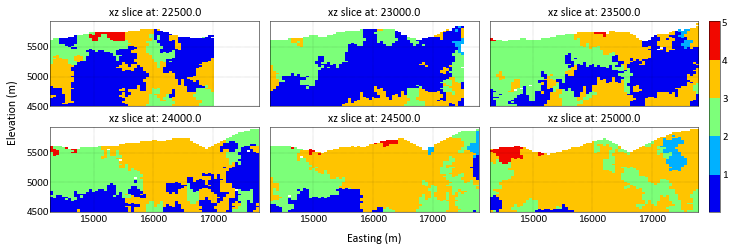

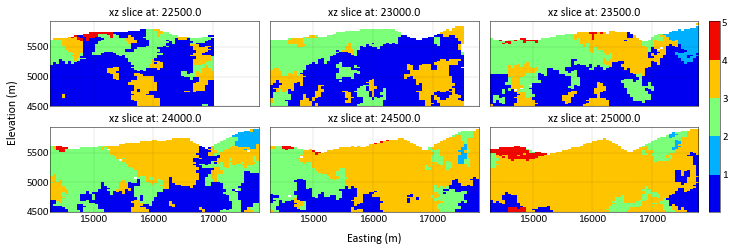

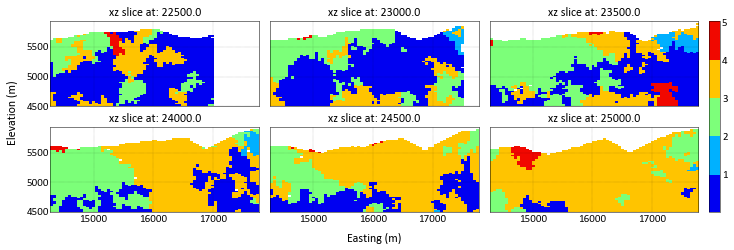

In [38]:
for i in range(nreals):
    a = np.where(np.isfinite(explicit['Formation']), sisim_pd['real {}'.format(i)], float('nan'))
    _ = gs.grid_slice_plot(a, griddef=grid, cmap='jet', grid=True, orient='xz', output_file='sisim_real_{}.png'.format(i), n_slice=6, figsize=(12,12))

In [42]:
pfields = gs.DataFile('tucs_models', griddef=grid)

In [43]:
pfields.head()

,boundary_simulation_80_600_0,boundary_simulation_80_600_1,boundary_simulation_80_600_10,boundary_simulation_80_600_2,boundary_simulation_80_600_3,boundary_simulation_80_600_4,boundary_simulation_80_600_5,boundary_simulation_80_600_6,boundary_simulation_80_600_7,boundary_simulation_80_600_8,boundary_simulation_80_600_9,boundary_simulation_80_600_num_cats_80.0
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


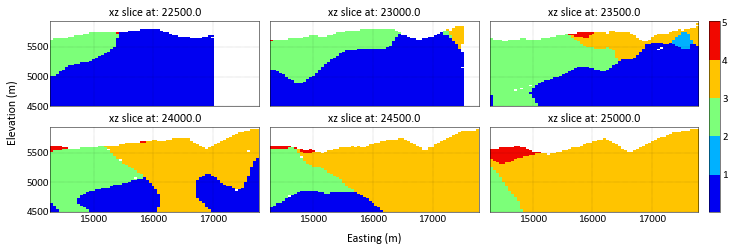

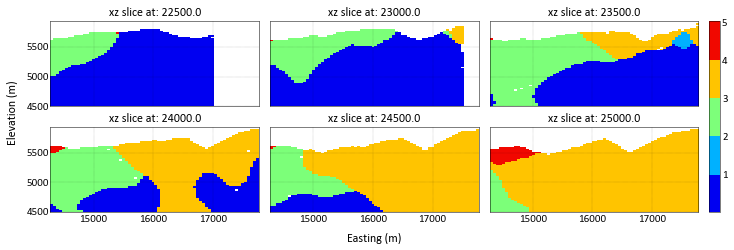

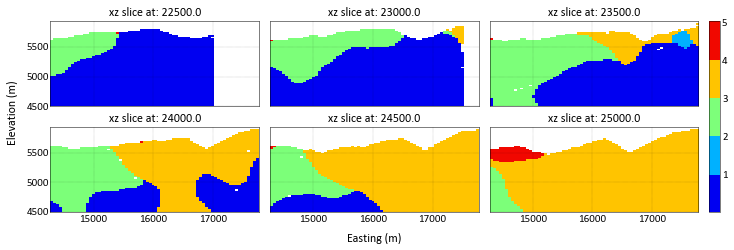

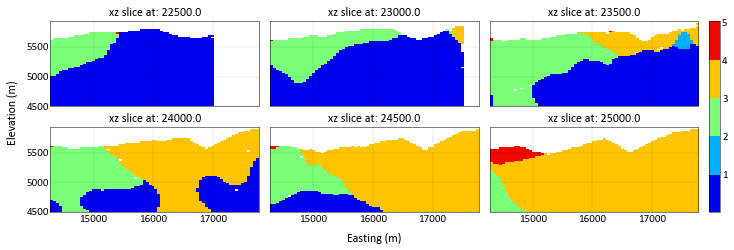

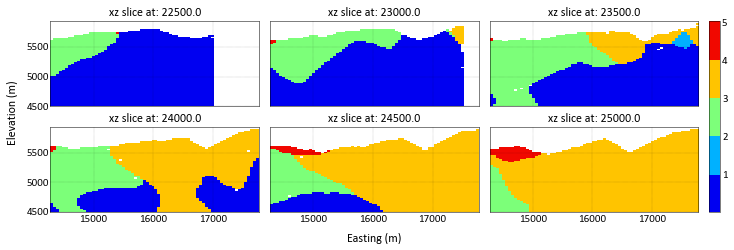

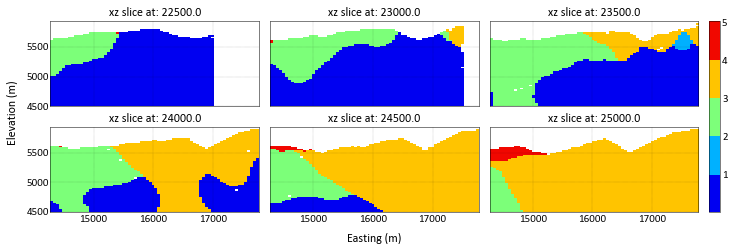

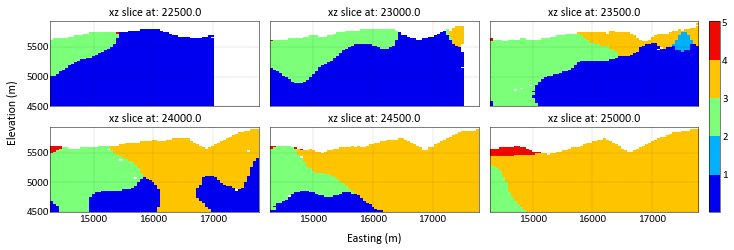

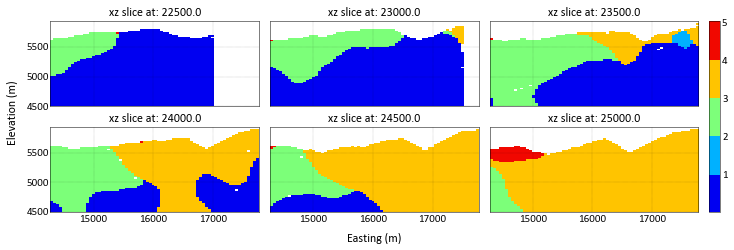

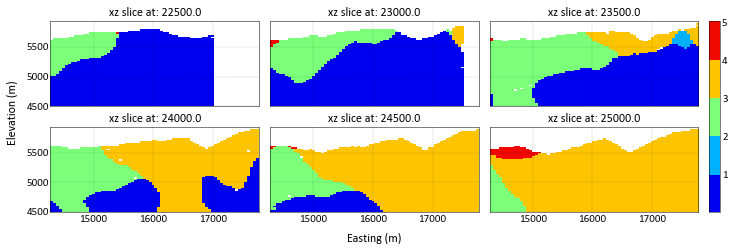

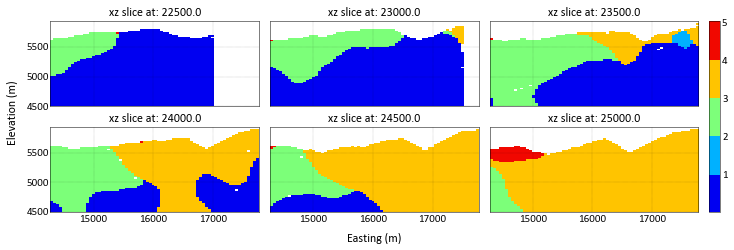

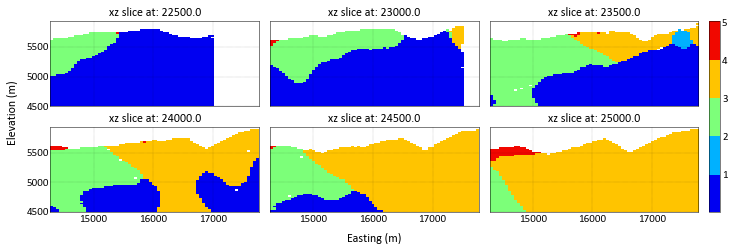

In [44]:
for i in range(nreals+1):
    _ = gs.grid_slice_plot(pfields['boundary_simulation_80_600_{}'.format(i)], griddef=grid, cmap='jet', grid=True, orient='xz', output_file='pfields_real_{}.png'.format(i), n_slice=6, figsize=(12,12))